1. Завдання щодо генерації текстів або машинного перекладу на базі рекурентних мереж або трансформерів. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import re

english_sentences = []
ukrainian_sentences = []

with open('ukr.txt', 'r', encoding='utf-8') as file:
    for line in file:
        parts = line.split('\t')
        if len(parts) >= 2:
            english_sentences.append(parts[0])
            ukrainian_sentences.append(parts[1])

print(english_sentences[:5])
print(ukrainian_sentences[:5])

['Go.', 'Hi.', 'Hi.', 'Hi.', 'Run!']
['Йди.', 'Вітаю!', 'Привіт.', 'Привіт!', 'Біжіть!']


In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(english_sentences)
eng_seq = eng_tokenizer.texts_to_sequences(english_sentences)
eng_vocab_size = len(eng_tokenizer.word_index)

ukr_tokenizer = Tokenizer()
ukr_tokenizer.fit_on_texts(ukrainian_sentences)
ukr_seq = ukr_tokenizer.texts_to_sequences(ukrainian_sentences)
ukr_vocab_size = len(ukr_tokenizer.word_index)

eng_seq = pad_sequences(eng_seq, maxlen=41, padding='post')
ukr_seq = pad_sequences(ukr_seq, maxlen=41, padding='post')

print(eng_seq.shape)
print(ukr_seq.shape)

(159432, 41)
(159432, 41)


In [4]:
eng_seq = eng_seq[:500000]
ukr_seq = ukr_seq[:500000]

In [5]:
eng_seq

array([[  41,    0,    0, ...,    0,    0,    0],
       [1338,    0,    0, ...,    0,    0,    0],
       [1338,    0,    0, ...,    0,    0,    0],
       ...,
       [  87, 5284, 2331, ...,    0,    0,    0],
       [   5, 5321, 1718, ...,    0,    0,    0],
       [  59,  235,    8, ...,  431, 1080,   14]])

In [6]:
ukr_seq

array([[  514,     0,     0, ...,     0,     0,     0],
       [ 3312,     0,     0, ...,     0,     0,     0],
       [ 1114,     0,     0, ...,     0,     0,     0],
       ...,
       [  124, 10651,  7943, ...,     0,     0,     0],
       [ 2649, 13284,     4, ...,     0,     0,     0],
       [    1,   509,     4, ...,     0,     0,     0]])

In [7]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, Dropout, LSTM, Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

In [8]:
model = Sequential()
model.add(Embedding(eng_vocab_size, 64, input_shape=eng_seq.shape[1:]))
model.add(GRU(64, return_sequences=True))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(ukr_vocab_size, activation='softmax'))

model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(0.001),
                  metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 41, 64)         │       678,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 41, 64)         │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 41, 64)         │         4,160 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 41, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 41, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 41, 31435)      │     2,043,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,755,147 (10.51 MB)

 Trainable params: 2,755,147 (10.51 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.fit(eng_seq, ukr_seq, batch_size=16, epochs=1, validation_split=0.3)

6975/6976 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9072 - loss: 0.9708

KeyboardInterrupt: 

In [ ]:
def translate_sentence(sentence):
    eng_seq_input = eng_tokenizer.texts_to_sequences([sentence])
    eng_seq_input = pad_sequences(eng_seq_input, maxlen=41, padding='post')

    pred = model.predict(eng_seq_input)
    
    translated_sentence = []
    for idx in np.argmax(pred, axis=-1)[0]:
        if idx != 0:  # 0 означає padding
            translated_sentence.append(ukr_tokenizer.index_word.get(idx, '?'))
    
    return ' '.join(translated_sentence)

In [ ]:
english_sentence = "the station is there"
ukrainian_translation = translate_sentence(english_sentence)
print(f"Переклад: {ukrainian_translation}")

2. Проведіть експерименти з моделями бібліотеки Hugging Face (раніше — Hugging Face Transformers, https://huggingface.co/) за допомогою (наприклад) Pipeline модуля.

In [9]:
from transformers import pipeline

classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
Device set to use 0


In [10]:
txt_1 = 'Football is the most exciting and popular game in the world'
print(f'{txt_1}: {classifier(txt_1)}')

txt_2 = 'The weather is unpredictable around here'
print(f'{txt_2}: {classifier(txt_2)}')

Football is the most exciting and popular game in the world: [{'label': 'POSITIVE', 'score': 0.9998573064804077}]
The weather is unpredictable around here: [{'label': 'POSITIVE', 'score': 0.6950825452804565}]


???

In [13]:
!pip install pytorch

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pytorch
Failed to build pytorch


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [6 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\Moony\AppData\Local\Temp\pip-install-eygotiu1\pytorch_b1d400ea58f1412dbeaf5509a3c51dd5\setup.py", line 15, in <module>
      raise Exception(message)
  Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pytorch)


In [12]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
model_name = "robinhad/ukrainian-qa"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

qa_model = pipeline("question-answering", model=model.to("cpu"), tokenizer=tokenizer)

ImportError: 
AutoModelForQuestionAnswering requires the PyTorch library but it was not found in your environment.
However, we were able to find a TensorFlow installation. TensorFlow classes begin
with "TF", but are otherwise identically named to our PyTorch classes. This
means that the TF equivalent of the class you tried to import would be "TFAutoModelForQuestionAnswering".
If you want to use TensorFlow, please use TF classes instead!

If you really do want to use PyTorch please go to
https://pytorch.org/get-started/locally/ and follow the instructions that
match your environment.


3. Завдання щодо генерації або стилізації зображень (на вибір). Вирішіть завдання перенесення стилю або генерації зображень (архітектура за вашим вибором: GAN/DCGAN/VAE/Diffusion).

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras import initializers

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1000)

In [19]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape[0], 'train samples')
print('image shape', x_train[0].shape)

60000 train samples
image shape (28, 28)


In [20]:
input_dim = 784
x_train = x_train.reshape(60000, input_dim)
print('input shape: ', x_train.shape[1])
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # normilization [-1, 1]

input shape:  784


In [22]:
optim = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [23]:
def build_discriminator():
    model =  keras.Sequential()
    model.add(layers.Dense(1024, input_dim=input_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
        
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
        
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [24]:
latent_dim = 100

def build_generator():
    model =  keras.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(input_dim, activation='tanh'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [25]:
discriminator = build_discriminator()
generator = build_generator()

# Combined network
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = keras.Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optim)

In [26]:
def plot_generated_images(epoch, generator):
    num_of_images = 10
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise).reshape(num_of_images, 28, 28)
    plt.figure()
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i], cmap = 'gray')
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [27]:
discrim_losses = []

def train_model(epochs, batch_size):
    num_batches = int(x_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
            
             # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9  # (instead of 1.0) sort of trick in GAN training, so called label smoothing
            # Train discriminator
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            discrim_losses.append(d_loss)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
        if ep % 20 == 0:
            print('epoch: ', ep)
            plot_generated_images(ep, generator)

In [28]:
epochs = 100
batch_size = 128
train_model(epochs, batch_size)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


AttributeError: 'NoneType' object has no attribute 'update_state'

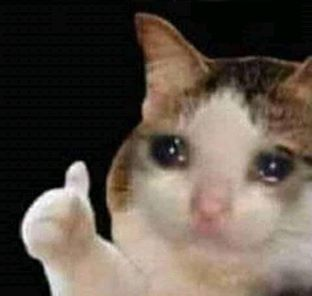